# DDPG & DDPGfD

DDPG - Deep Deterministic Policy Gradient <br>
DDPGfD - Deep Deterministic Policy Gradient from Demonstration


## Create a virtual display 🖥

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames).

Hence the following cell will install the librairies and create and run a virtual screen 🖥

In [1]:
!apt install swig cmake
!pip install swig

!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.1

!pip install moviepy==1.0.3




cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 64 not upgraded.
Need to get 1086 kB of archives.
After this operation, 5413 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig4.0 amd64 4.0.1-5build1 [1081 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig all 4.0.1-5build1 [5528 B]
Fetched 1086 kB in 2s (589 kB/s)

78Selecting previously unselected package swig4.0.
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.1-5build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 11%] [######....................................................] 8Unpacking swig4.0 (4.0.1-5build1) ...
7Progress: [ 22%] [#

In [2]:
!pip install gym[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.7 MB/s eta 0:00:00


In [3]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# DDPG

https://github.com/MrSyee/pg-is-all-you-need/blob/master/03.DDPG.ipynb

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN) ([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$\large
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Replay buffer
One challenge when using neural networks for reinforcement learning is that most optimization algorithms assume that **the samples are independently and identically distributed**. When the samples are generated from exploring sequentially in an environment this assumption no longer holds. The authors used a **replay buffer** to address these issues. Transitions were sampled from the environment according to the exploration policy and the tuple $(s_t, a_t, r_t, s_{t+1})$ was stored in the replay buffer. At each timestep the actor and critic are updated by sampling a minibatch uniformly from the buffer. It allows to benefit from learning across a set of **uncorrelated** transitions.

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target networks is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$\large
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$\large
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

## Import modules

In [4]:
import copy
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

from pathlib import Path
import datetime
import json
import imageio
import IPython
import base64

import tempfile

import os

## Set random seed

In [5]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [6]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)  # observation/state buffer
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32) # next state buffer
        self.acts_buf = np.zeros([size], dtype=np.float32) # actions buffer
        self.rews_buf = np.zeros([size], dtype=np.float32) # rewards buffer
        self.done_buf = np.zeros([size], dtype=np.float32) # done buffer
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

# OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$\large
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [8]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
        
        return action

In [9]:
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

# DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [10]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
                
        # noise
        self.noise = OUNoise(action_dim, theta=ou_noise_theta, sigma=ou_noise_sigma)

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:         
                state, _ = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                torch.save(self, 'model.pt')
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
                
        self.env.close()
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [11]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [12]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id, render_mode="rgb_array")
env = ActionNormalizer(env)

## Set random seed

In [13]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)
env.reset(seed=seed)

(array([ 0.7661138 ,  0.6427049 , -0.23436682], dtype=float32), {})

## Initialize

In [14]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

cpu


# Train DDPG Agent

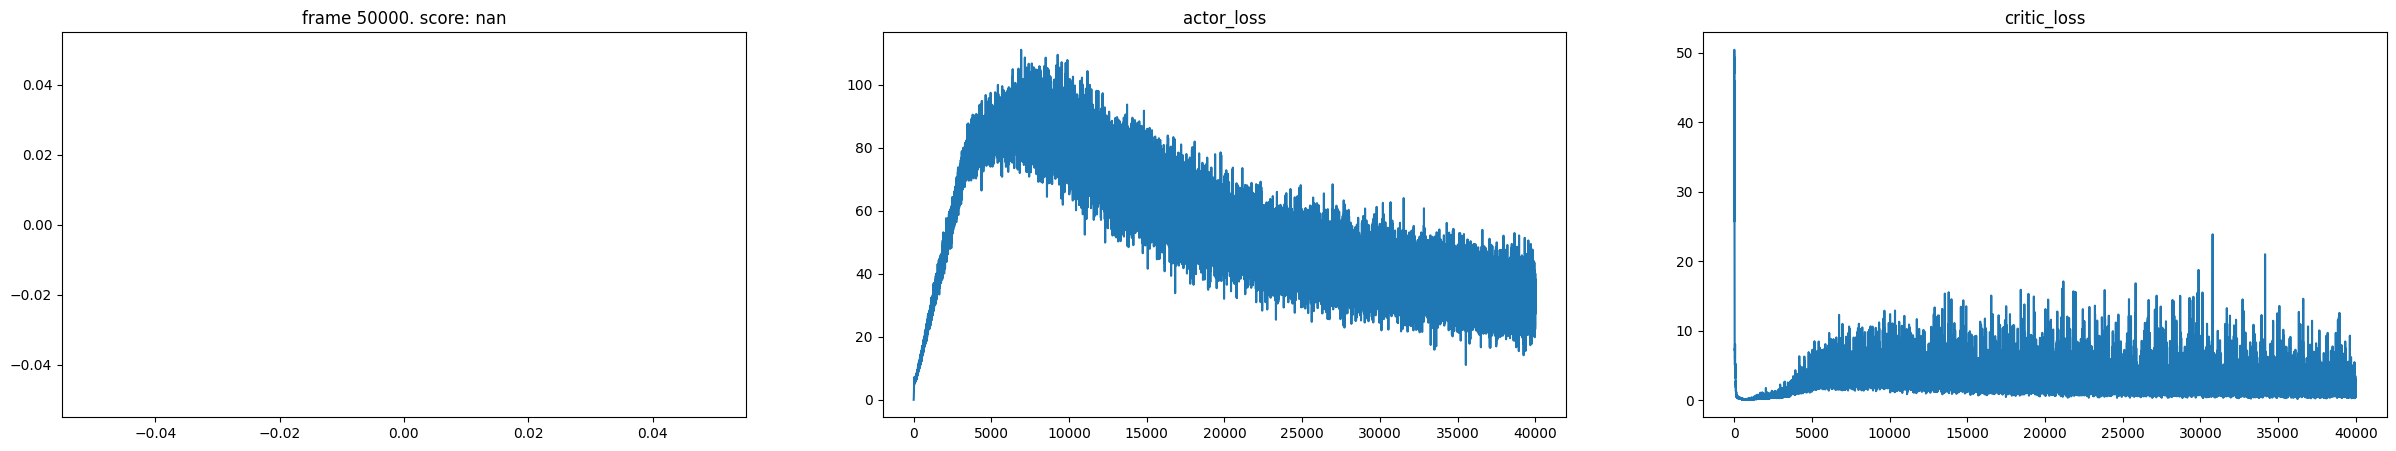

In [15]:
agent.train(num_frames)

# Validate DDPG Agent
Evaluate the trained agent

In [16]:
def evaluate_agent(env, max_steps, n_eval_episodes, agent):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    frames = []
    
    for step in range(max_steps):
      frames.append(agent.env.render()) 
      action = agent.select_action(state)
      new_state, reward, done, _, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, frames

In [17]:
agent = torch.load('/kaggle/working/model.pt')

In [18]:
# test
# agent.env = Monitor(agent.env, "videos", force=True)
# frames = agent.test()

eval_env = gym.make(env_id, render_mode='rgb_array')
mean_reward, std_reward, frames = evaluate_agent(eval_env, 1000, 10, agent)
print(mean_reward, std_reward)

-287.39216461548125 167.41060372916525


# Render DDPG Agent

In [19]:
def record_video(env, agent, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """

  images = []
  terminated = False
  truncated = False
  state, info = env.reset()
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = agent.select_action(state)
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
    if terminated or truncated:
        env.reset()
        break
  env.close()
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [20]:
record_video(env, agent, "replay.mp4", 30)

[swscaler @ 0x7217a00] Warning: data is not aligned! This can lead to a speed loss


In [21]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

embed_mp4('/kaggle/working/replay.mp4')

# DDPGfD

* **Full Documentation Step by Step:** https://wikidocs.net/204469
* **Implementation:** https://github.com/MrSyee/pg-is-all-you-need/blob/master/06.DDPGfD.ipynb

[M. Vecerik et al., "Leveraging Demonstrations for Deep Reinforcement Learning on Robotics Problems with Sparse Rewards."arXiv preprint arXiv:1707.08817, 2017](https://arxiv.org/pdf/1707.08817.pdf)

ReinforcementLearning (RL) offers, in principle, a method to learn such policies from exploration, but the amount of actual exploration required has prohibited its use in real applications. In this paper the authors address this challenge by combining the demonstration and RL paradigms into a single framework which uses demonstrations to guide a deep-RL algorithm. 

The central contribution of this paper is to show that off-policy replay-memory-based RL (e.g. DDPG) is a natural vehicle for injecting demonstration data into sparse-reward tasks and that it obviates the need for reward-shaping. 

The algorithms called DDPG from Demonstration (*DDPGfD*) modifies DDPG to take advantage of demonstrations.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Prioritized Experience Replay (PER)
DDPGfD uses prioritized replay to enable efficient propagation of the reward information, which is essential in problems with sparse rewards. Prioritized experience replay modifies the agent to sample more important transitions from its replay buffer more frequently.

The probability of sampling a particular transition is proportional to its priority,
$$\large
P(i) = \frac{p_i^{\alpha}}{\sum_k p_k^{\alpha}}
$$
, where $p_i$ the priority of the transition. The priority is commonly to use the magnitude of a transition’s TD error.

DDPGfD uses 
$$\large
p_i = \delta^{2}_{i} + \lambda_3 |\nabla_a Q(s_i, a_i|\theta^Q)|^2 + \epsilon + \epsilon_D,
$$
- $\delta_i$ is the last TD error calculated for this transition. The second term represents the loss applied to the actor.
- $\epsilon$ is a small positive constant to ensure all transitions are sampled with some probability.
- $\epsilon_D$ is a positive constant for demonstration transitions to increase their probability of getting sampled.
- $\lambda_3$ is used to weight the contributions.

One more. Let's recall one of the main ideas of DQN. To remove correlation of observations, it uses uniformly random sampling from the replay buffer. Prioritized replay introduces bias because it doesn't sample experiences uniformly at random due to the sampling proportion correspoding to TD-error. We can correct this bias by using importance-sampling (IS) weights

$$\large
w_i = \big( \frac{1}{N} \cdot \frac{1}{P(i)} \big)^\beta
$$

that fully compensates for the non-uniform probabilities $P(i)$ if $\beta = 1$. These weights can be folded into the Q-learning update by using $w_i\delta_i$ instead of $\delta_i$.

For details, refer to the PER paper ([T. Schaul et al., 2015.](https://arxiv.org/pdf/1511.05952.pdf))

### A mix of 1-step and n-step returns
A modification for the sparse reward case is to use a mix of 1-step and n-step returns when updating the critic function. Incorporating *n-step returns* helps propagate the Q-values along the trajectories.

The n-step return has the following form:
$$\large
R_n = \sum^{n-1}_{i=0} \gamma^i r_i + \gamma^n Q(s'_{n-1}, \pi(s'_{n-1}; \theta^{Q'}))
$$

The loss corresponding to this particular rollout is then:
$$\large
L_n(\theta^Q) = \frac{1}{2} (R_n - Q(s, \pi(s) | \theta^Q))^2
$$

### Loss function
The loss function is combined the above mentioned losses. Additionally *L2 regularization* on the parameters of the actor and the critic networks are added to stabilize the final learning performance. Two parameters called $\lambda_1$, $\lambda_2$ are used to weight the contributions.

$$\large
L_{Critic}(\theta ^ Q) = L_1(\theta^Q) + \lambda_1 L_n(\theta^Q) + \lambda_2 L^{C}_{reg} (\theta^Q)   \\
$$
$$\large
\nabla_{\theta^{\pi}} L_{Actor}(\theta^\pi) = - \nabla_{\theta^{\pi}} J(\theta^\pi) + \lambda_2 L^{A}_{reg} (\theta^\pi)
$$

### Pretrain
We make use of the demonstration data to pre-train the agent so that it can perform well in the task from the start of learning, and then continue improving from its own self-generated data.

Reference: 
- [Pseudo code of DDPGfD paper](https://arxiv.org/pdf/1707.08817.pdf)
- [DQfD](https://arxiv.org/pdf/1704.03732)

## DDPG from Demonstrations

To summarize, we modified the original DDPG algorithm in the following ways:

* Transitions from a human demonstrator are added to the replay buffer.
* Prioritized replay is used for sampling transitions across both the demonstration and agent data.
* A mix of 1-step and \(n\)-step return losses are used.
* Learning multiple times per environment step.
* L2 regularization losses on the weights of the critic and the actor are used.

## Full Algorithm

Here is psedocode of the DDPGfD alogrithm:

<img src="https://wikidocs.net/images/page/169334/Pseudo_DDPGfD.PNG" alt="DDPGfD Algorithm">

## Import modules

In [22]:
import os
import copy
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

if not os.path.exists("/kaggle/working/segment_tree.py") and not os.path.exists("/kaggle/working/demo.pkl"):
    # download segment tree module
    !wget https://raw.githubusercontent.com/mrsyee/pg-is-all-you-need/master/segment_tree.py
    # download demo.pkl
    !wget https://raw.githubusercontent.com/mrsyee/pg-is-all-you-need/master/demo.pkl
        
from segment_tree import MinSegmentTree, SumSegmentTree

--2024-06-19 08:18:35--  https://raw.githubusercontent.com/mrsyee/pg-is-all-you-need/master/segment_tree.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4268 (4.2K) [text/plain]
Saving to: 'segment_tree.py'

segment_tree.py     100%[===================>]   4.17K  --.-KB/s    in 0s      

2024-06-19 08:18:35 (33.9 MB/s) - 'segment_tree.py' saved [4268/4268]

--2024-06-19 08:18:36--  https://raw.githubusercontent.com/mrsyee/pg-is-all-you-need/master/demo.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179797 (176K) [applicati

## Set Random Seed 

In [23]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Replay buffer for N-step learning with demonstration

There are a little bit changes in Replay buffer for N-step learning with demonstration.

First, we use `deque` to store the most recent n-step transitions.

```python
    self.n_step_buffer = deque(maxlen=n_step)
```

You can see it doesn't actually store a transition in the buffer, unless `n_step_buffer` is full.

```
    # in store method
    if len(self.n_step_buffer) < self.n_step:
        return ()
```

When the length of `n_step_buffer` becomes equal to N, it eventually stores the N-step transition, which is calculated by `get_n_step_info` method (reference `util.py`). Furthermore, there are additional implementations for saving loaded demos. (Please see *03.DDPG.ipynb* for detailed description of the basic replay buffer.)

In [24]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32,         
                 gamma: float = 0.99, demo: list = None, n_step: int = 1):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)  # observation/state buffer
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32) # next state buffer
        self.acts_buf = np.zeros([size], dtype=np.float32) # actions buffer
        self.rews_buf = np.zeros([size], dtype=np.float32) # rewards buffer
        self.done_buf = np.zeros([size], dtype=np.float32) # done buffer
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma
        
        # for demonstration
        self.demo_size = len(demo) if demo else 0
        self.demo = demo
        
        if self.demo:
            self.ptr += self.demo_size
            self.size += self.demo_size
            for ptr, d in enumerate(self.demo):
                state, action, reward, next_state, done = d
                self.obs_buf[ptr] = state
                self.acts_buf[ptr] = np.array(action)
                self.rews_buf[ptr] = reward
                self.next_obs_buf[ptr] = next_state
                self.done_buf[ptr] = done

    def store(self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store the transition in buffer."""
        
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)
        
        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info()
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        
        self.ptr += 1
        self.ptr = self.demo_size if self.ptr % self.max_size == 0 else self.ptr
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self, indices: List[int] = None) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        assert len(self) >= self.batch_size
        
        if indices is None:
            indices = np.random.choice(len(self), size=self.batch_size, replace=False)
            
        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
            # for N-step learning
            indices=indices,
        )
    
    def _get_n_step_info(self) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = self.n_step_buffer[-1][-3:]

        for transition in reversed(list(self.n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + self.gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

# Prioritized Replay Buffer with demonstration

The key concept of PER's implementation is *Segment Tree*. It efficiently stores and samples transitions while managing the priorities of them (reference `segment_tree.py`). We recommend you understand how it works before you move on. Here are references for you:

- https://www.geeksforgeeks.org/segment-tree-set-1-sum-of-given-range/

In addtion, `epsilon_d` is a positive constant for demonstration transitions to increase their probability of getting sampled.

In [25]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer with demonstrations."""
    
    def __init__(self, obs_dim: int, size: int, batch_size: int = 32, 
        gamma: float = 0.99, alpha: float = 0.6, epsilon_d: float = 1.0,
        demo: list = None,
    ):
        """Initialize."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, gamma, demo, n_step=1 
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        self.epsilon_d = epsilon_d
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
        # for init priority of demo
        self.tree_ptr = self.demo_size
        for i in range(self.demo_size):
            self.sum_tree[i] = self.max_priority ** self.alpha
            self.min_tree[i] = self.max_priority ** self.alpha
        
    def store(self, obs: np.ndarray, act: int, rew: float, next_obs: np.ndarray, done: bool):
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha

            self.tree_ptr += 1
            if self.tree_ptr % self.max_size == 0:
                self.tree_ptr = self.demo_size
            
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        epsilon_d = np.array(
            [self.epsilon_d if i < self.demo_size else 0.0 for i in indices]
        )
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            epsilon_d=epsilon_d,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

# OU Noise
*Ornstein-Uhlenbeck* process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$\large
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [26]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, *ReLU* for hidden layers and *tanh* for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers *ReLU*. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are *uniformly distributed.*

In [27]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
        
        return action

In [28]:
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

# DDPGfD Agent
Here is a summary of DDPGfDAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_pretrain        |pretraining steps.|
|\_get_critic_loss   | return element-wise critic loss.                     |
|\_target_soft_update| soft update from the local model to the target model.|
|\_get_n_step_info_from_demo | return 1 step and n step demos. |

In [29]:
class DDPGfDAgent:
    """DDPGfDAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        demo (list): demonstration
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        pretrain_step (int): the number of step for pre-training
        n_step (int): the number of multi step
        use_n_step (bool): whether to use n_step memory
        prior_eps (float): guarantees every transitions can be sampled
        lambda1 (float): n-step return weight
        lambda2 (float): l2 regularization weight
        lambda3 (float): actor loss contribution of prior weight
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        demo: list,
        pretrain_step: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        # PER parameters
        alpha: float = 0.3,
        beta: float = 1.0,
        prior_eps: float = 1e-6,
        # N-step Learning
        n_step: int = 3,
        # loss parameters
        lambda1: float = 1.0, # N-step return weight
        lambda2: float = 1e-4, # l2 regularization weight
        lambda3: float = 1.0, # actor loss contribution of prior weight
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.batch_size = batch_size
        self.pretrain_step = pretrain_step
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.lambda1 = lambda1
        self.lambda3 = lambda3
        
        self.demo = demo
        demos_1_step, demos_n_step = [], []
        if self.demo:
            demos_1_step, demos_n_step = self._get_n_step_info_from_demo(demo, n_step)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(obs_dim, memory_size, batch_size, gamma, 
                                              alpha, demo=demos_1_step)
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(obs_dim, memory_size, batch_size, gamma, 
                                         demos_n_step, self.n_step)
                
        # noise
        self.noise = OUNoise(action_dim, theta=ou_noise_theta, sigma=ou_noise_sigma)

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4,weight_decay=lambda2)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3,weight_decay=lambda2)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            transition = self.transition
            if self.use_n_step:
                transition = self.memory_n.store(*self.transition)

            # add a single step transition
            if transition:
                self.memory.store(*transition)
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, ...]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch(self.beta)        
        state = torch.FloatTensor(samples["obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)

        weights = torch.FloatTensor(samples["weights"].reshape(-1, 1)).to(device)
        epsilon_d = samples["epsilon_d"]
        indices = samples["indices"]
        
        # train critic
        # 1-step loss
        critic_loss_element_wise = self._get_critic_loss(samples, self.gamma)
        critic_loss = torch.mean(critic_loss_element_wise * weights)
        
        # n-step loss
        if self.use_n_step:
            samples_n = self.memory_n.sample_batch(indices)
            n_gamma = self.gamma ** self.n_step
            critic_loss_n_element_wise = self._get_critic_loss(samples_n, n_gamma)
            
            # to update loss and priorities
            critic_loss_element_wise += (critic_loss_n_element_wise * self.lambda1)
            critic_loss = torch.mean(critic_loss_element_wise * weights) 
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        actor_loss_element_wise = -self.critic(state, self.actor(state))
        actor_loss = torch.mean(actor_loss_element_wise * weights)
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        # PER: update priorities
        new_priorities = critic_loss_element_wise
        new_priorities += self.lambda3 * actor_loss_element_wise.pow(2)
        new_priorities += self.prior_eps
        new_priorities = new_priorities.data.cpu().numpy().squeeze()
        new_priorities += epsilon_d
        self.memory.update_priorities(indices, new_priorities)
        
        # check the number of sampling demos
        demo_idxs = np.where(epsilon_d != 0.0)
        n_demo = demo_idxs[0].size
        
        return actor_loss.data, critic_loss.data, n_demo
    
    def _pretrain(self) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        """Pretraining steps."""
        actor_losses = []
        critic_losses = []
        print("Pre-Train %d step." % self.pretrain_step)
        for _ in range(1, self.pretrain_step + 1):
            actor_loss, critic_loss, _ = self.update_model()
            actor_losses.append(actor_loss.data)
            critic_losses.append(critic_loss.data)
        print("Pre-Train Complete!\n")
        return actor_losses, critic_losses
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset()
        actor_losses, critic_losses, n_demo_list, scores = [], [], [], []
        score = 0
        
        if self.demo:
            output = self._pretrain()
            actor_losses.extend(output[0])
            critic_losses.extend(output[1])
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # PER: increase beta
            fraction = min(self.total_step / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps):
                actor_loss, critic_loss, n_demo = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
                n_demo_list.append(n_demo)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                torch.save(self, 'model_fd.pt')
                self._plot(self.total_step, scores, actor_losses, critic_losses, n_demo_list)
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append()
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _get_critic_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return element-wise critic loss."""
        device = self.device  # for shortening the following lines
        
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + gamma * next_value * masks
        curr_return = curr_return.to(device).detach()

        # train critic
        values = self.critic(state, action)
        critic_loss_element_wise = (values - curr_return).pow(2)

        return critic_loss_element_wise
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _get_n_step_info_from_demo(self, demo: List, n_step: int) -> Tuple[List, List]:
        """Return 1 step and n step demos."""
        demos_1_step = list()
        demos_n_step = list()
        n_step_buffer: Deque = deque(maxlen=n_step)

        for transition in demo:
            n_step_buffer.append(transition)

            if len(n_step_buffer) == n_step:
                # add a single step transition
                demos_1_step.append(n_step_buffer[0])

                # add a multi step transition
                curr_state, action = n_step_buffer[0][:2]
                
                # get n-step info
                reward, next_state, done = n_step_buffer[-1][-3:]
                for transition in reversed(list(n_step_buffer)[:-1]):
                    r, n_o, d = transition[-3:]

                    reward = r + self.gamma * reward * (1 - d)
                    next_state, done = (n_o, d) if d else (next_state, done)
                
                transition = (curr_state, action, reward, next_state, done)
                demos_n_step.append(transition)

        return demos_1_step, demos_n_step
    
    def _plot(self, frame_idx: int, scores: List[float], actor_losses: List[float], 
              critic_losses: List[float], n_demo: List[int]):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)
                   
        subplot_params = [
            (141, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (142, "actor_loss", actor_losses),
            (143, "critic_loss", critic_losses),
            (144, "the number of sampling demos", n_demo),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))            
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [30]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [31]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id, render_mode="rgb_array")
env = ActionNormalizer(env)

## Initialize
We make the demonstration using the well-trained agent in advance. (The given demo.pkl is created transitions using *03.DDPG* agent.)

In [32]:
import pickle

# load demo on replay memory
demo_path = "demo.pkl"
with open(demo_path, "rb") as f:
    demo = pickle.load(f)

In [33]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000
n_step = 3
pretrain_step = 1000

agent = DDPGfDAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    demo,
    n_step=n_step,
    pretrain_step=pretrain_step,
    initial_random_steps=initial_random_steps,
)

cpu


/tmp/ipykernel_18/3481442492.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.acts_buf[ptr] = np.array(action)


# Train DDPGfD Agent

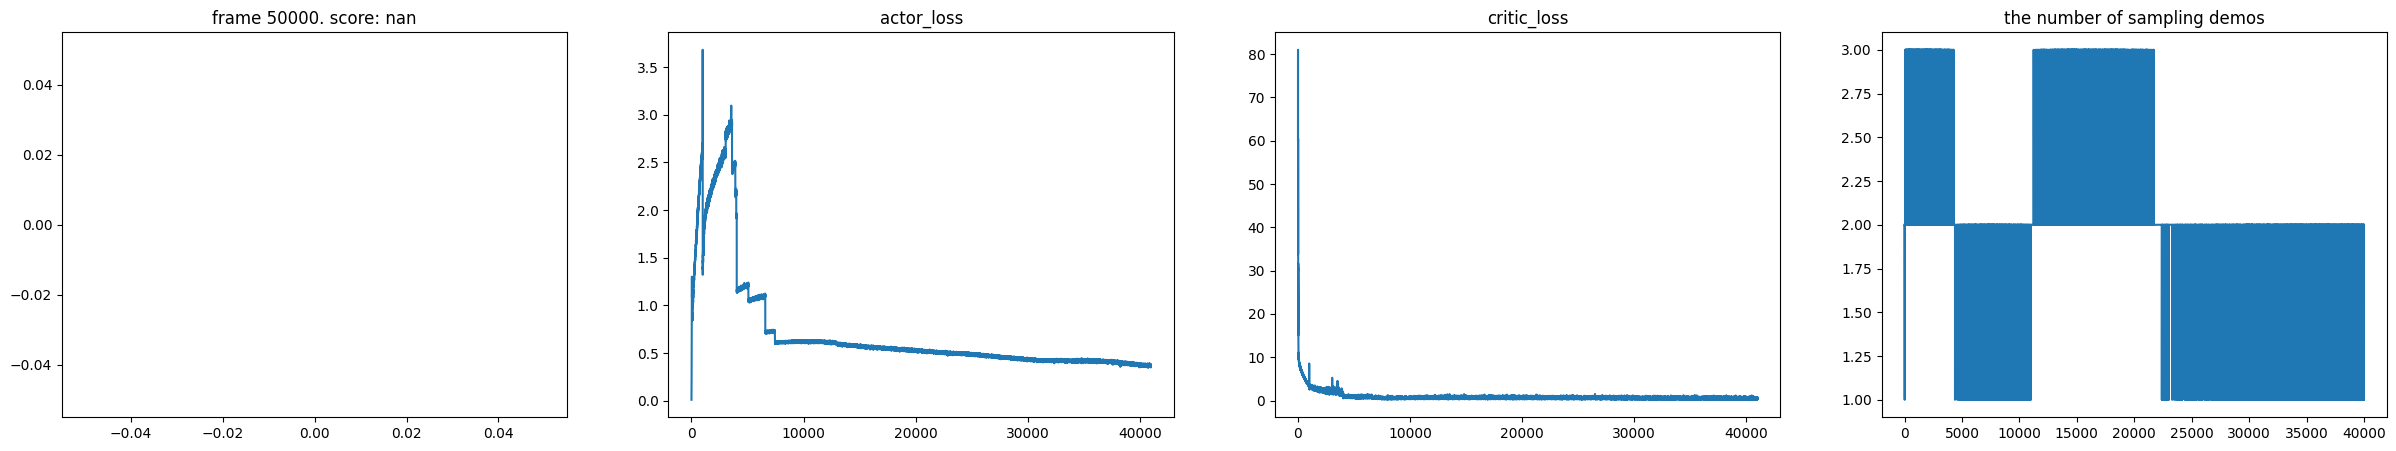

In [34]:
agent.train(num_frames)

# Validate DDPGfD Agent
Evaluate the trained agent

In [35]:
def evaluate_agent(env, max_steps, n_eval_episodes, agent):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    frames = []
    
    for step in range(max_steps):
      frames.append(agent.env.render()) 
      action = agent.select_action(state)
      new_state, reward, done, _, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, frames

In [36]:
agent = torch.load('/kaggle/working/model_fd.pt')

In [37]:
eval_env = gym.make(env_id, render_mode='rgb_array')
mean_reward, std_reward, frames = evaluate_agent(eval_env, 1000, 10, agent)
print(mean_reward, std_reward)

-2980.717475819714 85.33479233411204


# Render DDPGfD Agent

In [38]:
def record_video(env, agent, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """

  images = []
  terminated = False
  truncated = False
  state, info = env.reset()
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = agent.select_action(state)
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
    if terminated or truncated:
        env.reset()
        break
  env.close()
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [39]:
record_video(env, agent, "replay_fd.mp4", 30)

[swscaler @ 0x675ba00] Warning: data is not aligned! This can lead to a speed loss


In [40]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

embed_mp4('/kaggle/working/replay_fd.mp4')